<div align=center>
		
<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
<font color=#4d7db8>
Sharif University of Technology - Department of Electrical Engineering
</font>
<p></p>
<font color=#4d7db8>
Introduction To Machine Learning - Dr. Sajjad Amini
</font>
<br/>
<br/>
Spring Semester 1401-02

<div/>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
        Project - 3rd Phase
        <br />
        Image Colorization using Autoencoder
			</font>
    <br/>
<font size=4>
			<br/><br/>
Due on Tir 10th
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=green>
Should you have any questions concerning the project, please feel free to ask via Telegram.
     </font>
</font>
                <br/>
    </div>

# Personal Info
<hr/>
    <div class="column" align=center>
    <font size=4>
        <div class="column">
        <br />
            student_number = <font color='yellow'> 99102507 </font>
            <br />
            Name = <font color='yellow'> Amir Hossein  </font>
            <br />
            Last_Name = <font color='yellow'> Yari </font>
        </div>
        <div class="column">
        <br />
            student_number = <font color='yellow'> 99104232 </font>
            <br />
            Name = <font color='yellow'> Amir Hossein  </font>
            <br />
            Last_Name = <font color='yellow'> Moraveji </font>
        </div>
    </font>
    </div>


1. Download the "landscape image colorization" dataset and slice it to `train_set`, `validation_set` and `test_set`.
2. Design and train an AutoEncoder using `PyTorch` (not `TensorFlow`) on the dataset to colorize grayscale images
3. plot learning curve and visualize grayscale images of test set, their corresponding color images and their colorized versions side by side.

# Import Necessary Libraries

In [1]:
import os
import numpy as np
import random
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize
import matplotlib.pyplot as plt

# Load Dataset and Prepare It

In [2]:
dataset_dir = "landscape Images"

color_dir = os.path.join(dataset_dir, "color")
gray_dir = os.path.join(dataset_dir, "gray")

color_filenames = os.listdir(color_dir)
gray_filenames = os.listdir(gray_dir)

random.seed(42)  # Set random seed for reproducibility

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

num_samples = len(color_filenames)
num_train = int(train_ratio * num_samples)
num_val = int(val_ratio * num_samples)
num_test = int(test_ratio * num_samples)

train_color_filenames = color_filenames[:num_train]
val_color_filenames = color_filenames[num_train:num_train+num_val]
test_color_filenames = color_filenames[num_train+num_val:]

train_gray_filenames = gray_filenames[:num_train]
val_gray_filenames = gray_filenames[num_train:num_train+num_val]
test_gray_filenames = gray_filenames[num_train+num_val:]

def load_images(filenames, folder):
    images = []
    for filename in filenames:
        img = Image.open(os.path.join(folder, filename))
        images.append(np.array(img))
    return images

train_color_images = load_images(train_color_filenames, color_dir)
val_color_images = load_images(val_color_filenames, color_dir)
test_color_images = load_images(test_color_filenames, color_dir)

train_gray_images = load_images(train_gray_filenames, gray_dir)
val_gray_images = load_images(val_gray_filenames, gray_dir)
test_gray_images = load_images(test_gray_filenames, gray_dir)

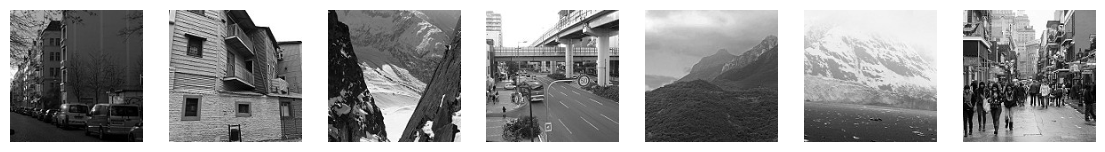

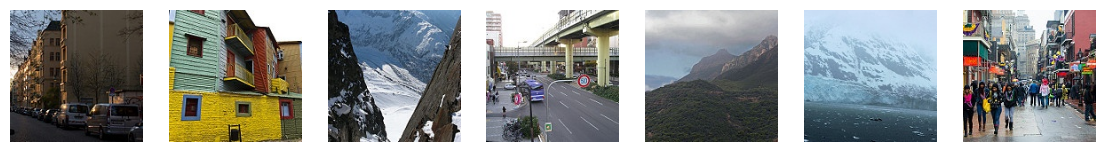

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(14, 6))
for i in range(7):
    axes[i].imshow(train_gray_images[i], cmap='gray')
    axes[i].axis('off')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(14, 6))
for i in range(7):
    axes[i].imshow(train_color_images[i], cmap='gray')
    axes[i].axis('off')
plt.show()

# Define Your Model

In [4]:
# Set random seed for reproducibility
random.seed(42)
torch.manual_seed(42)

class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=0),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class ColorizationDataset(Dataset):
    def __init__(self, gray_images, color_images, transform=None):
        self.gray_images = gray_images
        self.color_images = color_images
        self.transform = transform

    def __len__(self):
        return len(self.gray_images)

    def __getitem__(self, idx):
        gray_img = self.gray_images[idx]
        color_img = self.color_images[idx]

        # Convert numpy arrays to PIL images
        gray_img = Image.fromarray(gray_img)
        color_img = Image.fromarray(color_img)

        # Resize the images to a consistent size
        resize_transform = Resize((150, 150))
        gray_img = resize_transform(gray_img)
        color_img = resize_transform(color_img)

        if self.transform:
            gray_img = self.transform(gray_img)
            color_img = self.transform(color_img)

        return gray_img, color_img

# Fit The Model

Also Define optimizer, Criterion and other parameters 

In [6]:
# Define the image transformation
transform = ToTensor()

# Create the datasets
train_dataset = ColorizationDataset(train_gray_images, train_color_images, transform=transform)
val_dataset = ColorizationDataset(val_gray_images, val_color_images, transform=transform)
test_dataset = ColorizationDataset(test_gray_images, test_color_images, transform=transform)

# Create the data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model
model = ColorizationModel()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        total_val_loss = 0.0
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, targets)
            total_val_loss += val_loss.item()
        epoch_val_loss = total_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
    
    # Print losses
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss}, Val Loss: {epoch_val_loss}")


Epoch 1/10, Train Loss: 0.026925820343865033, Val Loss: 0.014718507623506917
Epoch 2/10, Train Loss: 0.01306528390910572, Val Loss: 0.011951478570699692
Epoch 3/10, Train Loss: 0.009897912959926404, Val Loss: 0.00871398581398858
Epoch 4/10, Train Loss: 0.008365715991180295, Val Loss: 0.007840759855591588
Epoch 5/10, Train Loss: 0.007578046783470573, Val Loss: 0.007171953210814132
Epoch 6/10, Train Loss: 0.007144627032968669, Val Loss: 0.007435108772996399
Epoch 7/10, Train Loss: 0.0069071208037292725, Val Loss: 0.0064842173208793
Epoch 8/10, Train Loss: 0.006599413165345023, Val Loss: 0.006692623378088077
Epoch 9/10, Train Loss: 0.006358730588824703, Val Loss: 0.006508560095810228
Epoch 10/10, Train Loss: 0.006314955708475258, Val Loss: 0.006955603282484743


# Plot The Results

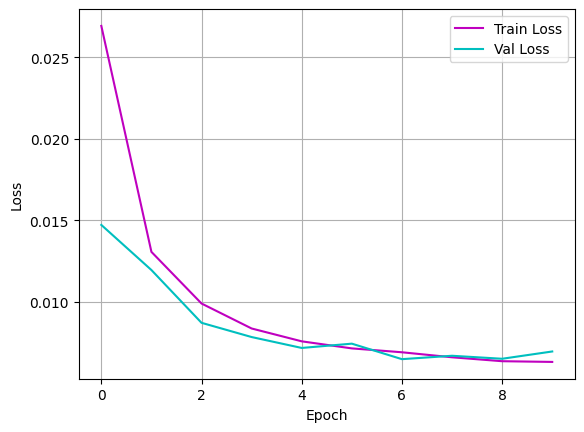

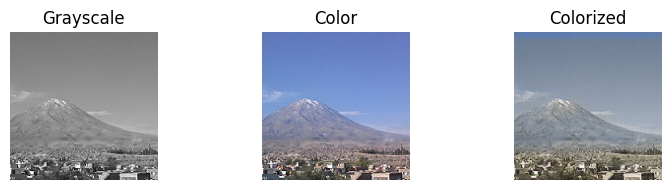

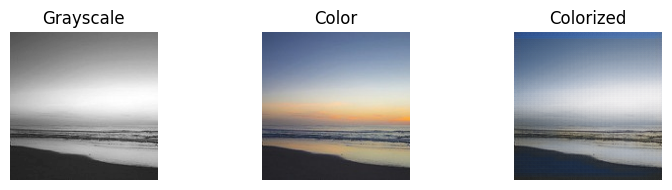

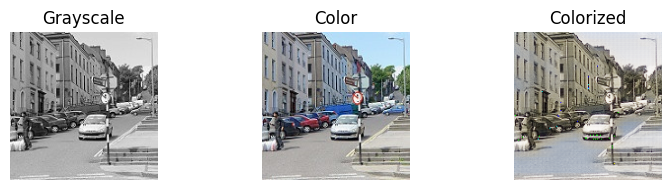

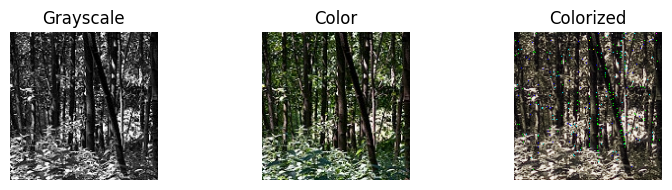

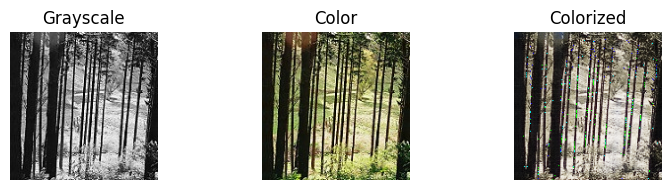

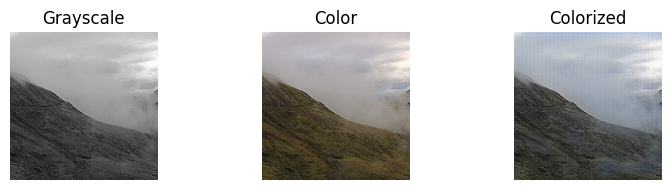

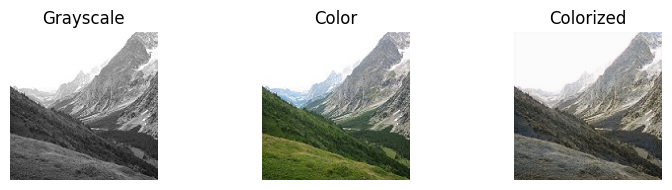

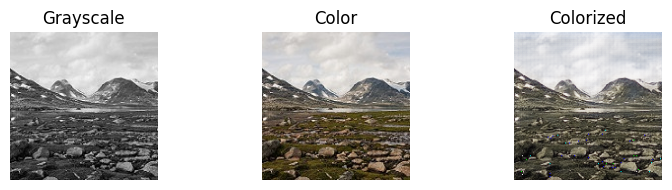

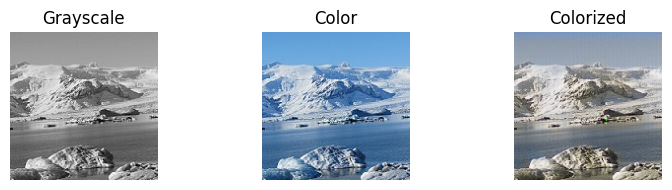

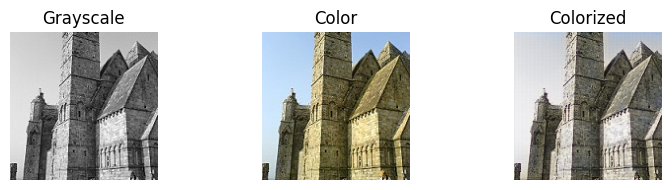

In [44]:
# Plot the learning curve
plt.figure()
plt.plot(range(num_epochs), train_losses, label='Train Loss', color="m")
plt.plot(range(num_epochs), val_losses, label='Val Loss', color="c")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Select a few random samples from the test set
num_samples = 10
indices = torch.randperm(len(test_dataset))[:num_samples]

model.eval()

# Iterate over the selected samples
for index in indices:
    gray_img, color_img = test_dataset[index]
    gray_img = gray_img.unsqueeze(0).to(device)

    # Forward pass through the model to get the colorized image
    with torch.no_grad():
        colorized_img = model(gray_img)
        colorized_img = colorized_img.squeeze(0).cpu()

    # Convert tensors to PIL images for visualization
    gray_img = transforms.ToPILImage()(gray_img.squeeze(0).cpu())
    color_img = transforms.ToPILImage()(color_img.cpu())
    colorized_img = transforms.ToPILImage()(colorized_img)

    # Plot the grayscale, color, and colorized images
    fig, axes = plt.subplots(1, 3, figsize=(8, 2))
    axes[0].imshow(gray_img, cmap='gray')
    axes[0].set_title('Grayscale')
    axes[1].imshow(color_img)
    axes[1].set_title('Color')
    axes[2].imshow(colorized_img)
    axes[2].set_title('Colorized')
    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')
    plt.tight_layout()
    plt.show()